# This notebook studies how new sets of labels appear in time and how frequently they'll reappear in the future

### Import dataset

In [2]:
import pandas as pd

In [3]:
PATH = "../Dataset_preparation_and_inference/Datasets/Cyberlab"
predicted_corpus = pd.read_csv(f"{PATH}/corpus_with_predictions.csv")
predicted_corpus.head(2)

session_id                                       full_session  \
0           0  enable ; system ; shell ; sh ; cat /proc/mount...   
1           1  enable ; system ; shell ; sh ; cat /proc/mount...   

         sensor                   first_timestamp  \
0  eea5dc653b37  2019-06-04 09:45:11.151186+00:00   
1  eea5dc653b37  2019-06-04 09:45:50.396610+00:00   

                                   Predicted_classes  \
0  Discovery -- Discovery -- Discovery -- Discove...   
1  Discovery -- Discovery -- Discovery -- Discove...   

                                  Models_predictions  
0  Discovery -- Discovery -- Discovery -- Discove...  
1  Discovery -- Discovery -- Discovery -- Discove...

In [4]:
from datetime import datetime
server_update_date = datetime.strptime("08/11/2019", '%d/%m/%Y').date()
server_update_datetime = datetime.strptime("08/11/2019", '%d/%m/%Y')

print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


#### Create date attribute

In [5]:
predicted_corpus["first_timestamp"] = pd.to_datetime(predicted_corpus["first_timestamp"])
predicted_corpus["date"] = predicted_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
predicted_corpus.head(2)

session_id                                       full_session  \
0           0  enable ; system ; shell ; sh ; cat /proc/mount...   
1           1  enable ; system ; shell ; sh ; cat /proc/mount...   

         sensor                  first_timestamp  \
0  eea5dc653b37 2019-06-04 09:45:11.151186+00:00   
1  eea5dc653b37 2019-06-04 09:45:50.396610+00:00   

                                   Predicted_classes  \
0  Discovery -- Discovery -- Discovery -- Discove...   
1  Discovery -- Discovery -- Discovery -- Discove...   

                                  Models_predictions        date  
0  Discovery -- Discovery -- Discovery -- Discove...  2019-06-04  
1  Discovery -- Discovery -- Discovery -- Discove...  2019-06-04

#### Plot distribution of intents over time

In [6]:
sessions_date_predictions = predicted_corpus[["full_session", "Models_predictions", "date"]]
sessions_date_predictions["splitted_session"] = sessions_date_predictions["full_session"].apply(lambda session: session.split(" "))
sessions_date_predictions["splitted_prediction"] = sessions_date_predictions["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = sessions_date_predictions[["splitted_session", "splitted_prediction", "date"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Exploded dataset contains 28150954 rows and 3 columns


splitted_session splitted_prediction        date
0           enable           Discovery  2019-06-04
0                ;           Discovery  2019-06-04

##### Groupby date

In [7]:
occurrences_x_day = exploded_df.groupby(["date", "splitted_prediction"]).size().reset_index(name = "daily_occurrences")
occurrences_x_day.head(5)

date splitted_prediction  daily_occurrences
0  2019-06-04     Defense Evasion                660
1  2019-06-04           Discovery               4123
2  2019-06-04           Execution               1546
3  2019-06-05     Defense Evasion                802
4  2019-06-05           Discovery               6680

##### Calculate CDF

In [8]:
occurrences_x_day["cumulative_occurrences"] = occurrences_x_day.groupby(['splitted_prediction'])['daily_occurrences'].cumsum()
occurrences_x_day = occurrences_x_day.merge(occurrences_x_day.groupby("splitted_prediction")["daily_occurrences"].sum().reset_index(name = "tot_occurrences"), on = "splitted_prediction")
occurrences_x_day["cdf"] = occurrences_x_day.apply(lambda row: row["cumulative_occurrences"] / row["tot_occurrences"], axis = 1)
occurrences_x_day.head(2)

date splitted_prediction  daily_occurrences  cumulative_occurrences  \
0  2019-06-04     Defense Evasion                660                     660   
1  2019-06-05     Defense Evasion                802                    1462   

   tot_occurrences       cdf  
0           138774  0.004756  
1           138774  0.010535

#### Create colors

In [9]:
import seaborn as sns
bars = occurrences_x_day.drop_duplicates("splitted_prediction").sort_values(by = "tot_occurrences", ascending = False)
palette = sns.color_palette("bright", bars.splitted_prediction.nunique())
role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette)}
hex_role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette.as_hex())}

#### Fill missing dates with NaN

In [10]:
def plot_cdfs(cdf, dates):
    cdf = cdf.copy().set_index("date")
    cdf.index = pd.DatetimeIndex(cdf.index)
    cdf = cdf.reindex(dates, method = 'ffill') #Every prediction must be equally indexed: if no improvements that day, put last valid value
    return cdf.asfreq('D')

##### Plot

In [11]:
dates = occurrences_x_day.date.unique()

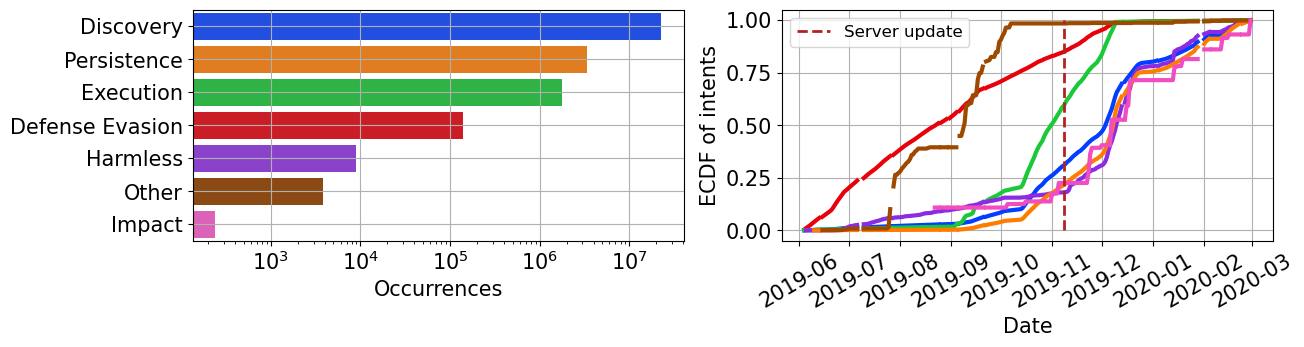

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize =(12, 3))
fontsize = 15
#Axis 1
sns.barplot(data=bars, x="tot_occurrences", y ="splitted_prediction", hue = "splitted_prediction", dodge = False, palette = role2color, ax = axs[0])
axs[0].legend_.remove()
axs[0].set_xlabel('Occurrences', fontsize = fontsize)
axs[0].set_ylabel("")
axs[0].set_xscale("log")
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)
axs[0].grid()
#Axis 2

for role in occurrences_x_day.splitted_prediction.unique():
    cdf = occurrences_x_day[occurrences_x_day.splitted_prediction == role][["date", "cdf"]]
    cdf = plot_cdfs(cdf, dates)
    axs[1].plot(cdf.index, cdf.cdf, color = role2color[role], linewidth = 3)
    
#sns.lineplot(data=occurrences_x_day, x="date", y ="cdf", hue = "splitted_prediction", palette = role2color, ax = axs[1], linewidth = 3)
axs[1].vlines(server_update_date, 0, 1, label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs[1].set_xlabel('Date', fontsize = fontsize)
axs[1].set_ylabel('ECDF of intents', fontsize = fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)
axs[1].xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
axs[1].legend(fontsize = fontsize - 3, ncol = 1)
axs[1].grid()
plt.subplots_adjust(left=.1, bottom=None, right=1, top=None, wspace=None, hspace=None)

#### Now, let's visualize the sequence of intents (maybe highlighting the ones with a prediction we want to investigate from plot above)

##### For each label, save first date in which we've seen that label

In [13]:
predicted_corpus.sort_values(by = "first_timestamp", inplace = True)
first_appearance_per_prediction = predicted_corpus.groupby("Models_predictions")["date"].agg("first").reset_index()
first_appearance_per_prediction.sort_values(by = "date", ascending = True, inplace = True)
first_appearance_per_prediction.head(2)

Models_predictions        date
1493  Execution -- Execution -- Execution -- Executi...  2019-06-04
1285  Execution -- Execution -- Execution -- Executi...  2019-06-04

##### Now, trick to easily count labels occurrences

In [14]:
predictions_per_day = predicted_corpus.groupby("date")["Models_predictions"].agg(list).reset_index().rename({"Models_predictions":"Predictions_per_day"}, axis = 1)
predictions_per_day["Predictions_per_day"] = predictions_per_day["Predictions_per_day"].apply(lambda list_predictions: " __ ".join(list_predictions))
predictions_per_day.head(2)

date                                Predictions_per_day
0  2019-06-04  Discovery -- Discovery -- Discovery -- Discove...
1  2019-06-05  Discovery -- Discovery -- Discovery -- Discove...

##### Doing that, each row will contain dates. Each column will be associated to a prediction

In [15]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split(" __ ")]

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase = False, binary = True)
X = vectorizer.fit_transform(predictions_per_day.Predictions_per_day).toarray()
names = vectorizer.get_feature_names_out()
df_count_vectorizer = pd.DataFrame(X, columns=names, index = predictions_per_day.date)
print(f"Dataframe has shape {df_count_vectorizer.shape[0]} x {df_count_vectorizer.shape[1]}")
#df_count_vectorizer.set_index([pd.Index(predictions_per_day.date.values)])

Dataframe has shape 257 x 1673


#### Plot

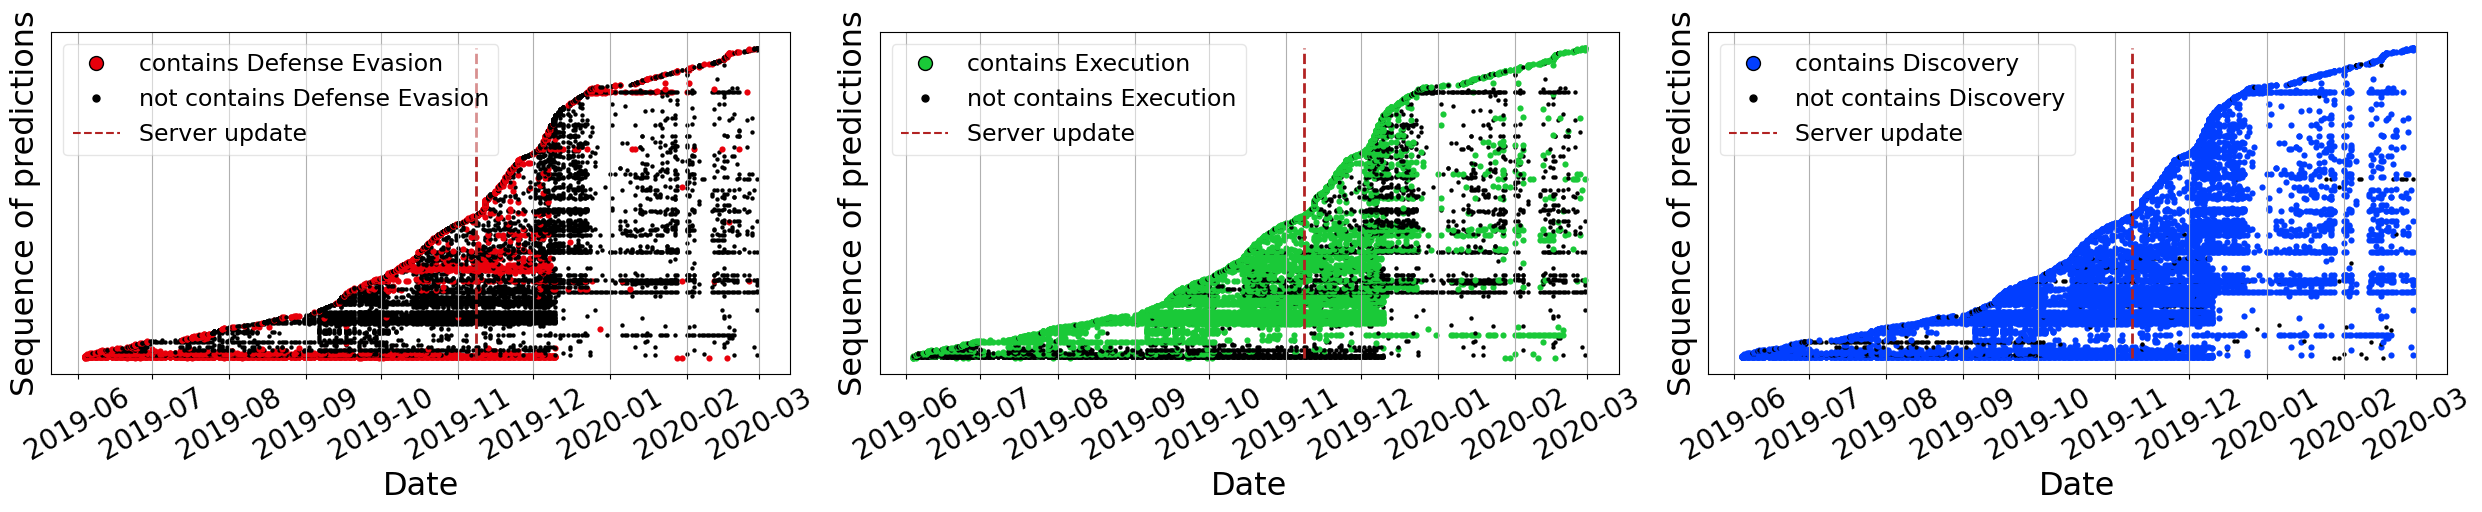

In [17]:
import matplotlib as mpl
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 3, figsize=(25,5))
fontsize = 20
df_count_vectorizer = df_count_vectorizer.reindex(sorted(df_count_vectorizer.columns), axis=1)
n_days = df_count_vectorizer.shape[0]
y_values = []

for ax, prediction_of_interest in zip(axs, ["Defense Evasion", "Execution", "Discovery"]):
    # Define colors and sizes of points
    colors = {1: {"color":role2color[prediction_of_interest], "size": 20}, 0: {"color":"black", "size": 10}}
    for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
        prediction = first_appearance_per_prediction.iloc[it].Models_predictions
        is_of_interest = 1 if prediction_of_interest in prediction else 0
        x_coord = df_count_vectorizer.index.values # dates
        y_coord = (it +1) * df_count_vectorizer[prediction].values.astype('float') # present/non present according to prediction under analysis (each gets a new row)
        y_coord[y_coord == 0] = 'nan'
        c = colors[is_of_interest]["color"]
        s = colors[is_of_interest]["size"]
        scatters = ax.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")
        if is_of_interest == 1 and prediction_of_interest == "Execution":
            y_values.append(it +1)
            
    ax.vlines(server_update_datetime, 0, first_appearance_per_prediction.shape[0], label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")    
    ax.set_ylabel('Sequence of predictions', fontsize = fontsize + 3)
    ax.set_xlabel('Date', fontsize = fontsize + 3)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  

    point_major = Line2D([0], [0], label=f"contains {prediction_of_interest}", markersize=20, markerfacecolor=role2color[prediction_of_interest], linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
    point_minor = Line2D([0], [0], label= f"not contains {prediction_of_interest}", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
    server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
    # add manual symbols to auto legend
    ax.legend(handles=[point_major, point_minor, server_update], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
    ax.grid()
plt.tight_layout()
plt.show()

#### Select one tactic and plot most frequent words

In [18]:
tactic2word = predicted_corpus.copy()
tactic2word["splitted_session"] = tactic2word["full_session"].apply(lambda session: session.split(" "))
tactic2word["splitted_prediction"] = tactic2word["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = tactic2word[["splitted_session", "splitted_prediction", "date", "session_id"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 28150954 rows and 4 columns


splitted_session splitted_prediction        date  session_id
0           enable           Discovery  2019-06-04           0
0                ;           Discovery  2019-06-04           0

##### Count how many unique tuples ("word", "prediction")

In [19]:
grouped_df = exploded_df.groupby(["splitted_session", "splitted_prediction"]).size().reset_index(name = "occurrences_tuple")
print(f"The dataset contains {grouped_df.shape[0]} unique tuples")
grouped_df.head(2)

The dataset contains 411753 unique tuples


splitted_session splitted_prediction  occurrences_tuple
0  206.196.180.220^C           Execution                  1
1                 ^C           Discovery                  1

#### Now, focus on 1 intent (e.g., "Persistence")

In [20]:
persistence_df = grouped_df[grouped_df["splitted_prediction"] == "Persistence"]
print(f"Selected {persistence_df.shape[0]} unique tuples (word, 'Persistence')")
persistence_df.head(2)

Selected 325854 unique tuples (word, 'Persistence')


splitted_session splitted_prediction  occurrences_tuple
485      !QAZ2wsx#EDC4rfv"         Persistence                 86
486  !QAZ2wsx#EDC4rfv%TGB"         Persistence                  2

##### Filter non-alpha words

In [21]:
import re
persistence_df["is_alpha"] = persistence_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
persistence_df["is_flag"] = persistence_df["splitted_session"].apply(lambda word: "-" in word)

filtered_persistence_df = persistence_df[(persistence_df.is_alpha == True) & (persistence_df.is_flag == False)]
print(f"Selected {filtered_persistence_df.shape[0]} rows")
filtered_persistence_df.head(2)

Selected 324291 rows


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


splitted_session splitted_prediction  occurrences_tuple  is_alpha  \
485      !QAZ2wsx#EDC4rfv"         Persistence                 86      True   
486  !QAZ2wsx#EDC4rfv%TGB"         Persistence                  2      True   

     is_flag  
485    False  
486    False

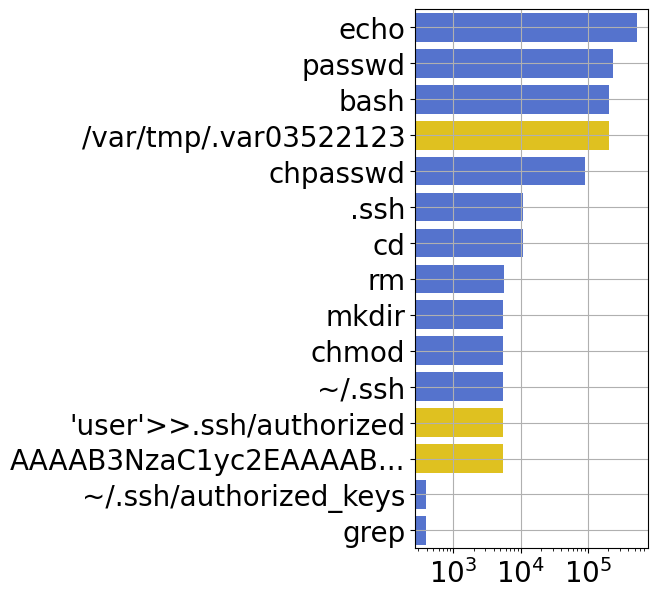

In [22]:
y_ticks = ["echo", "passwd", "bash","/var/tmp/.var03522123", "chpasswd", ".ssh", "cd", "rm", "mkdir", "chmod", "~/.ssh", "'user'>>.ssh/authorized", "AAAAB3NzaC1yc2EAAAAB...", "~/.ssh/authorized_keys","grep"]
top_20 = filtered_persistence_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:20]
top_20["splitted_session"] = top_20["splitted_session"].apply(lambda word: word[:25])
top_20["is_of_interest"] = top_20["splitted_session"].apply(lambda word: 1 if word in ['mdrfckr">>.ssh/authorized', '"root', "AAAAB3NzaC1yc2EAAAABJQAAA", "/var/tmp/.var03522123"] else 0)
top_20 = top_20[~top_20["splitted_session"].isin(["LC_ALL=C", ">>~/.ssh/authorized_keys", "go=", "AAAAB3NzaC1yc2EAAAADAQABA"])]

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_20, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest",dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"}, errwidth = 0)
axs.get_legend().remove()
axs.set_xscale("log")
#axs.set_xlabel('occurrences of (word, "Persistence")', fontsize = fontsize)
axs.set_ylabel("")
axs.set_xlabel("")
#axs.set_xticks([0, 500, 1000])
axs.set_yticks(np.arange(len(y_ticks)))
axs.set_yticklabels(y_ticks)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()
plt.savefig("./Inference_results/4_Forensic/persistence.pdf",dpi=300, bbox_inches = "tight")

#### Now, focus on 1 intent (e.g., "Execution")

In [23]:
execution_df = grouped_df[grouped_df["splitted_prediction"] == "Execution"]
print(f"Selected {execution_df.shape[0]} unique tuples (word, 'Execution')")
execution_df.head(2)

Selected 5950 unique tuples (word, 'Execution')


splitted_session splitted_prediction  occurrences_tuple
0  206.196.180.220^C           Execution                  1
3                              Execution                  2

##### Filter non-alpha words

In [24]:
import re
execution_df["is_alpha"] = execution_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
execution_df["is_flag"] = execution_df["splitted_session"].apply(lambda word: "-" in word)

filtered_execution_df = execution_df[(execution_df.is_alpha == True) & (execution_df.is_flag == False)]
print(f"Selected {filtered_execution_df.shape[0]} rows")
filtered_execution_df.head(2)

Selected 5355 rows


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


splitted_session splitted_prediction  occurrences_tuple  is_alpha  \
0  206.196.180.220^C           Execution                  1      True   
5                 cd           Execution                  1      True   

   is_flag  
0    False  
5    False

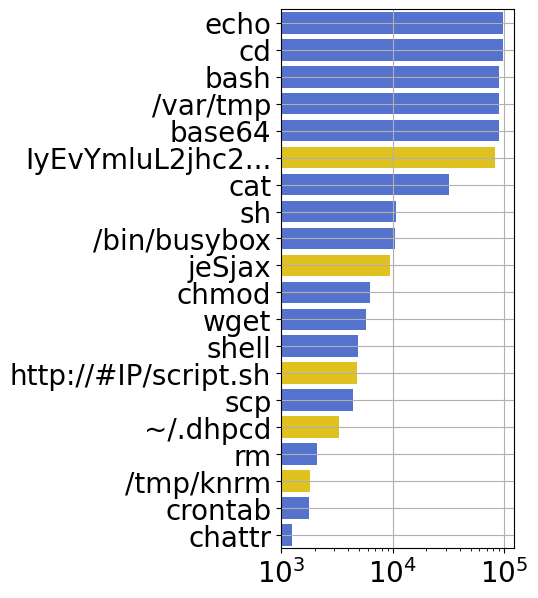

In [25]:
top_30 = filtered_execution_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:30]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda word: word[:30])
top_30 = top_30.drop_duplicates("splitted_session")
top_30["is_of_interest"] = top_30["splitted_session"].apply(lambda word: 1 if (word in ["~/.dhpcd", "jeSjax", "http://23.254.230.38/p3n1s.sh", "/tmp/knrm"]) or ("IyEvY" in word) else 0)
#top_30 = top_30[~top_30["splitted_session"].str.contains("IyEvY")]
top_30 = top_30[~top_30["splitted_session"].isin(["15s", "/tmp", "/var/tmp/.systemcache436621", "LC_ALL=C", "/tmp/r", "/home/admin/.dhpcd", "sleep", "/tmp/jeSjax", "$SHELL"])]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda el: "IyEvYmluL2jhc2..." if ("IyEvY" in el) else el)
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda el: "http://#IP/script.sh" if ("p3n1s" in el) else el)

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_30, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest", dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"})
axs.get_legend().remove()
axs.set_xscale("log")
axs.set_xlabel('')
axs.set_ylabel("")
axs.set_xticks([1000, 10000, 100000])
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()
plt.savefig("./Inference_results/4_Forensic/execution.pdf",dpi=300, bbox_inches = "tight")

#### Same, with Execution

#### Now, the same keeping only 1st session per sequence of intents

In [26]:
unique_corpus = predicted_corpus.sort_values(by = "date").drop_duplicates(["Models_predictions"])
print(f"Selected {unique_corpus.shape[0]} rows")
unique_corpus.head(2)

Selected 1673 rows


session_id                                       full_session  \
0            0  enable ; system ; shell ; sh ; cat /proc/mount...   
59          59  enable ; system ; shell ; sh ; cat /proc/mount...   

          sensor                  first_timestamp  \
0   eea5dc653b37 2019-06-04 09:45:11.151186+00:00   
59  eea5dc653b37 2019-06-04 19:26:26.930419+00:00   

                                    Predicted_classes  \
0   Discovery -- Discovery -- Discovery -- Discove...   
59  Discovery -- Discovery -- Discovery -- Discove...   

                                   Models_predictions        date  
0   Discovery -- Discovery -- Discovery -- Discove...  2019-06-04  
59  Discovery -- Discovery -- Discovery -- Discove...  2019-06-04

##### Explode dataset, so that each row contains a word and a prediction

In [27]:
unique_corpus["splitted_session"] = unique_corpus["full_session"].apply(lambda session: session.split(" "))
unique_corpus["splitted_prediction"] = unique_corpus["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = unique_corpus[["splitted_session", "splitted_prediction", "date", "session_id"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 319732 rows and 4 columns


splitted_session splitted_prediction        date  session_id
0           enable           Discovery  2019-06-04           0
0                ;           Discovery  2019-06-04           0

##### Drop duplicated > so that if a word appear multiple times in the same session it is only counted once

In [28]:
exploded_df = exploded_df.drop_duplicates()
print(f"Considering only 1 occurence per session, the number of rows reduced to {exploded_df.shape[0]}")

Considering only 1 occurence per session, the number of rows reduced to 92276


##### Count how many unique tuples ("word", "prediction")

In [29]:
grouped_df = exploded_df.groupby(["splitted_session", "splitted_prediction"]).size().reset_index(name = "occurrences_tuple")
print(f"The dataset contains {grouped_df.shape[0]} unique tuples")
grouped_df.head(2)

The dataset contains 7479 unique tuples


splitted_session splitted_prediction  occurrences_tuple
0  206.196.180.220^C           Execution                  1
1                 ^C           Discovery                  1

#### Now, focus on 1 intent (e.g., "Persistence")

In [30]:
persistence_df = grouped_df[grouped_df["splitted_prediction"] == "Persistence"]
print(f"Selected {persistence_df.shape[0]} unique tuples (word, 'Persistence')")
persistence_df.head(2)

Selected 1110 unique tuples (word, 'Persistence')


splitted_session splitted_prediction  occurrences_tuple
28  !QAZ2wsx#EDC4rfv%TGB"         Persistence                  1
30      !QAZ2wsx3edc4rfv"         Persistence                  1

##### Filter non-alpha words

In [31]:
import re
persistence_df["is_alpha"] = persistence_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
persistence_df["is_flag"] = persistence_df["splitted_session"].apply(lambda word: "-" in word)

filtered_persistence_df = persistence_df[(persistence_df.is_alpha == True) & (persistence_df.is_flag == False)]
print(f"Selected {filtered_persistence_df.shape[0]} rows")
filtered_persistence_df.head(2)

Selected 1081 rows


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


splitted_session splitted_prediction  occurrences_tuple  is_alpha  \
28  !QAZ2wsx#EDC4rfv%TGB"         Persistence                  1      True   
30      !QAZ2wsx3edc4rfv"         Persistence                  1      True   

    is_flag  
28    False  
30    False

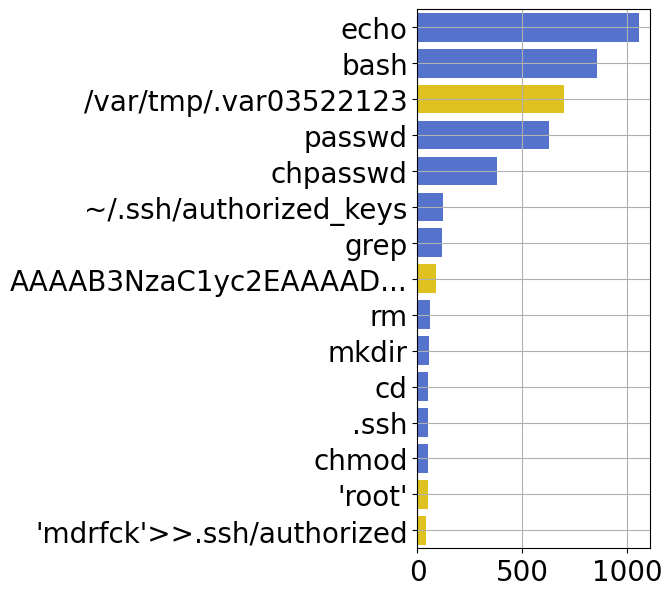

In [32]:
y_ticks = ["echo", "bash","/var/tmp/.var03522123", "passwd","chpasswd", 
           "~/.ssh/authorized_keys","grep","AAAAB3NzaC1yc2EAAAAD...",
           "rm","mkdir", "cd",".ssh", "chmod", "'root'", "'mdrfck'>>.ssh/authorized"]
top_20 = filtered_persistence_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:20]
top_20["splitted_session"] = top_20["splitted_session"].apply(lambda word: word[:25])
#top_30["occurrences_tuple"] = top_30["occurrences_tuple"].apply(lambda occurrence: occurrence / filtered_execution_df.shape[0] * 100)
top_20["is_of_interest"] = top_20["splitted_session"].apply(lambda word: 1 if word in ['mdrfckr">>.ssh/authorized', '"root', "AAAAB3NzaC1yc2EAAAADAQABA", "/var/tmp/.var03522123"] else 0)
top_20 = top_20[~top_20["splitted_session"].str.contains("^C")]
top_20 = top_20[~top_20["splitted_session"].isin(["LC_ALL=C", ">>~/.ssh/authorized_keys", "~/.ssh"])]

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_20, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest",dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"}, errwidth = 0)
axs.get_legend().remove()
#axs.set_xlabel('occurrences of (word, "Persistence")', fontsize = fontsize)
axs.set_ylabel("")
axs.set_xlabel("")
axs.set_xticks([0, 500, 1000])
axs.set_yticks(np.arange(len(y_ticks)))
axs.set_yticklabels(y_ticks)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()
plt.savefig("./Inference_results/4_Forensic/persistence.pdf",dpi=300, bbox_inches = "tight")

#### Now, focus on 1 intent (e.g., "Execution")

In [33]:
execution_df = grouped_df[grouped_df["splitted_prediction"] == "Execution"]
print(f"Selected {execution_df.shape[0]} unique tuples (word, 'Execution')")
execution_df.head(2)

Selected 2770 unique tuples (word, 'Execution')


splitted_session splitted_prediction  occurrences_tuple
0  206.196.180.220^C           Execution                  1
3                              Execution                  1

##### Filter non-alpha words

In [34]:
import re
execution_df["is_alpha"] = execution_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
execution_df["is_flag"] = execution_df["splitted_session"].apply(lambda word: "-" in word)

filtered_execution_df = execution_df[(execution_df.is_alpha == True) & (execution_df.is_flag == False)]
print(f"Selected {filtered_execution_df.shape[0]} rows")
filtered_execution_df.head(2)

Selected 2482 rows


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


splitted_session splitted_prediction  occurrences_tuple  is_alpha  \
0  206.196.180.220^C           Execution                  1      True   
5                 cd           Execution                  1      True   

   is_flag  
0    False  
5    False

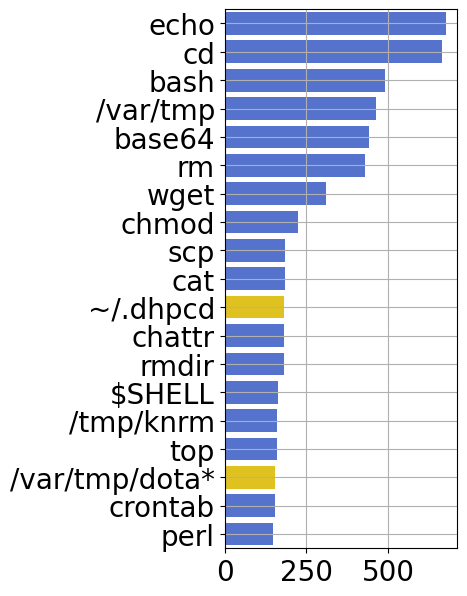

In [35]:
top_30 = filtered_execution_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:30]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda word: word[:30])
#top_30["occurrences_tuple"] = top_30["occurrences_tuple"].apply(lambda occurrence: occurrence / filtered_execution_df.shape[0] * 100)
top_30["is_of_interest"] = top_30["splitted_session"].apply(lambda word: 1 if word in ["~/.dhpcd", "/var/tmp/dota*"] else 0)
top_30 = top_30[~top_30["splitted_session"].str.contains("IyEvY")]
top_30 = top_30[~top_30["splitted_session"].isin(["15s", "/tmp", "/var/tmp/.systemcache436621", "LC_ALL=C", "2>/dev/null", ">/dev/null", "sleep", "/tmp/r", "/home/admin/.dhpcd", "/var/spool/cron/crontabs/root"])]

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_30, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest", dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"})
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel("")
axs.set_xticks([0, 250, 500])
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()
plt.savefig("./Inference_results/4_Forensic/execution.pdf",dpi=300, bbox_inches = "tight")

### Investigate one of the following (i.e., dhpcd)
#### Select only rows that contain the chosen word

In [36]:
from datetime import datetime
print(f"Before filtering, we had {predicted_corpus.shape[0]} sessions")
upper_date = datetime.strptime("01/01/2020", '%d/%m/%Y').date()

corpus_of_chosen_word = predicted_corpus[(predicted_corpus.full_session.str.contains("~/.dhpcd")) & (predicted_corpus.date < upper_date)]
print(f"After filtering, we selected {corpus_of_chosen_word.shape[0]} sessions")

Before filtering, we had 233035 sessions
After filtering, we selected 664 sessions


##### How many sequences of predictions associated?

In [37]:
corpus_of_chosen_word.sort_values(by = "first_timestamp", inplace = True)
first_appearance_chosen_word = corpus_of_chosen_word.groupby("Models_predictions")["date"].agg("first").reset_index()
print(f"There are {first_appearance_chosen_word.shape[0]} unique sequences of predictions associated")
first_appearance_chosen_word.sort_values(by = "date").head(2)

There are 182 unique sequences of predictions associated


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Models_predictions        date
137  Execution -- Execution -- Execution -- Executi...  2019-09-18
136  Execution -- Execution -- Execution -- Executi...  2019-09-19

##### Also take into account how many sessions were associated to each sequence

In [38]:
sessions_per_seq = corpus_of_chosen_word.groupby("Models_predictions")["full_session"].count().reset_index(name = "associated_sessions")
birth_and_occurrences = first_appearance_chosen_word.merge(sessions_per_seq, on = "Models_predictions")
print("Displaying examples in the order of date of birth:")
birth_and_occurrences.sort_values(by = "date").head(5)

Displaying examples in the order of date of birth:


Models_predictions        date  \
137  Execution -- Execution -- Execution -- Executi...  2019-09-18   
136  Execution -- Execution -- Execution -- Executi...  2019-09-19   
129  Execution -- Execution -- Execution -- Executi...  2019-09-20   
4    Discovery -- Discovery -- Discovery -- Discove...  2019-09-20   
128  Execution -- Execution -- Execution -- Executi...  2019-09-23   

     associated_sessions  
137                    2  
136                    3  
129                    4  
4                      4  
128                    2

In [39]:
print("Displaying examples in the order of associated sessions:")
birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).head(5)

Displaying examples in the order of associated sessions:


Models_predictions        date  \
162  Execution -- Execution -- Execution -- Executi...  2019-10-08   
52   Discovery -- Discovery -- Discovery -- Discove...  2019-10-08   
23   Discovery -- Discovery -- Discovery -- Discove...  2019-10-07   
79   Discovery -- Discovery -- Discovery -- Discove...  2019-10-07   
161  Execution -- Execution -- Execution -- Executi...  2019-10-10   

     associated_sessions  
162                  104  
52                    51  
23                    40  
79                    24  
161                   23

#### Now plot again distribution over time, focusing only on the sequences containing the chosen word

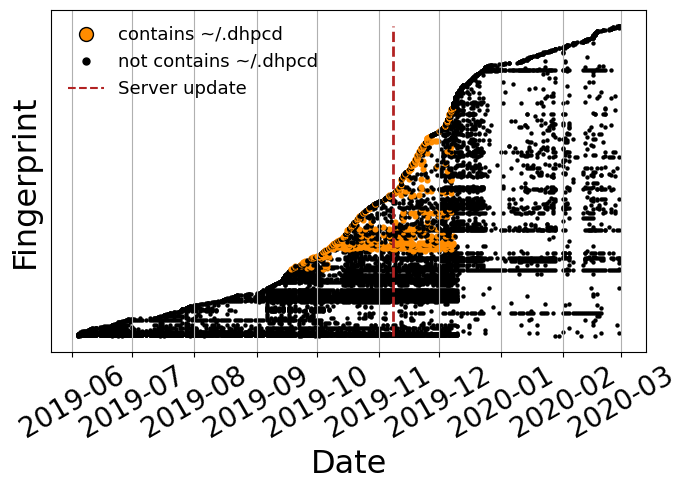

In [41]:
fig, ax = plt.subplots(1, figsize=(7,5))
fontsize = 20
colors = {1: {"color":"darkorange", "size": 20}, 0: {"color":"black", "size": 10}}
for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
    prediction = first_appearance_per_prediction.iloc[it].Models_predictions
    is_of_interest = 1 if prediction in list(first_appearance_chosen_word.Models_predictions.values) else 0
    x_coord = df_count_vectorizer.index.values # dates
    y_coord = (it + 1) * df_count_vectorizer[prediction].values.astype('float') # present/non present according to prediction under analysis (each gets a new row)
    y_coord[y_coord == 0] = 'nan'
    c = colors[is_of_interest]["color"]
    s = colors[is_of_interest]["size"]
    scatters = ax.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")

ax.set_ylabel('Fingerprint', fontsize = fontsize + 3)
ax.set_xlabel('Date', fontsize = fontsize + 3)
ax.yaxis.set_ticks([])
ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  
x_labels = ax.get_xticklabels()
ax.vlines(server_update_datetime, 0, first_appearance_per_prediction.shape[0], label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")    
server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
point_major = Line2D([0], [0], label=f"contains ~/.dhpcd", markersize=20, markerfacecolor="darkorange", linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
point_minor = Line2D([0], [0], label= f"not contains ~/.dhpcd", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
# add manual symbols to auto legend
ax.legend(handles=[point_major, point_minor, server_update], fontsize = fontsize - 7, loc = "upper left", framealpha=0.0)
ax.grid()
plt.tight_layout()
plt.savefig("./Inference_results/over_time_dhpcd.png")

#### Another visualization:

In [40]:
df_associated_sessions_per_date = corpus_of_chosen_word.groupby(["Models_predictions", "date"])["full_session"].count().reset_index(name = "associated_sessions")
df_associated_sessions_per_date = df_associated_sessions_per_date.sort_values(by = "date")
df_associated_sessions_per_date.head(2)

Models_predictions        date  \
375  Execution -- Execution -- Execution -- Executi...  2019-09-18   
372  Execution -- Execution -- Execution -- Executi...  2019-09-19   

     associated_sessions  
375                    1  
372                    1

In [41]:
ids_predictions = birth_and_occurrences.sort_values(by = "date")[["Models_predictions"]].reset_index(drop = True).reset_index().rename({"index": "Prediction_id"}, axis = 1)
ids_predictions.head(2)

Prediction_id                                 Models_predictions
0              0  Execution -- Execution -- Execution -- Executi...
1              1  Execution -- Execution -- Execution -- Executi...

In [42]:
df_associated_sessions_per_date = df_associated_sessions_per_date.merge(ids_predictions, on = "Models_predictions")
df_associated_sessions_per_date = df_associated_sessions_per_date[df_associated_sessions_per_date.Prediction_id != df_associated_sessions_per_date.Prediction_id.max()]
df_associated_sessions_per_date.head(2)

Models_predictions        date  \
0  Execution -- Execution -- Execution -- Executi...  2019-09-18   
1  Execution -- Execution -- Execution -- Executi...  2019-10-04   

   associated_sessions  Prediction_id  
0                    1              0  
1                    1              0

#### Visualization

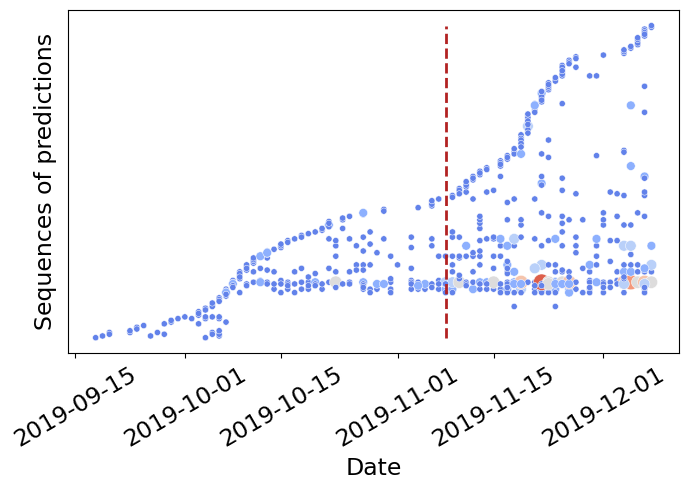

In [43]:
fig, axs = plt.subplots(figsize =(7, 5))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(20, 20*unique_associated_sessions.shape[0] + 1, 20))}
palette = sns.color_palette("coolwarm", len(sizes))
sns.scatterplot(df_associated_sessions_per_date, palette = palette, x = "date", y = "Prediction_id", hue = "associated_sessions", size = "associated_sessions", sizes = sizes, ax = axs, legend = None)
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
#handles = [server_update]
#for size, color in zip(sizes.keys(), palette):
#    handles.append(Line2D([0], [0], label=f"{size} sessions associated", markersize=sizes[size]/10+5, markerfacecolor=color, linewidth = .2, markeredgecolor="k", marker='.', linestyle=''))
# add manual symbols to auto legend
#axs.legend(handles=handles, fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()

##### Focus on attacks with more sessions associated

In [44]:
dates_of_interest = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:10].date.values
upper_date_threshold = np.max(dates_of_interest)
lower_date_threshold = np.min(dates_of_interest)
upper_date_threshold, lower_date_threshold

(datetime.date(2019, 10, 17), datetime.date(2019, 10, 7))

In [45]:
session_threshold = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:10].associated_sessions.iloc[-1]
session_threshold

13

In [46]:
predictions_of_interest = birth_and_occurrences[(birth_and_occurrences.date >= lower_date_threshold) & \
                                                (birth_and_occurrences.date <= upper_date_threshold) & \
                                                (birth_and_occurrences.associated_sessions >= session_threshold)].Models_predictions

In [47]:
df_associated_sessions_per_date_of_interest = df_associated_sessions_per_date[df_associated_sessions_per_date.Models_predictions.isin(predictions_of_interest)]
df_associated_sessions_per_date_not_of_interest = df_associated_sessions_per_date[~df_associated_sessions_per_date.Models_predictions.isin(predictions_of_interest)]
print(df_associated_sessions_per_date_of_interest.shape[0], df_associated_sessions_per_date_not_of_interest.shape[0])

229 306


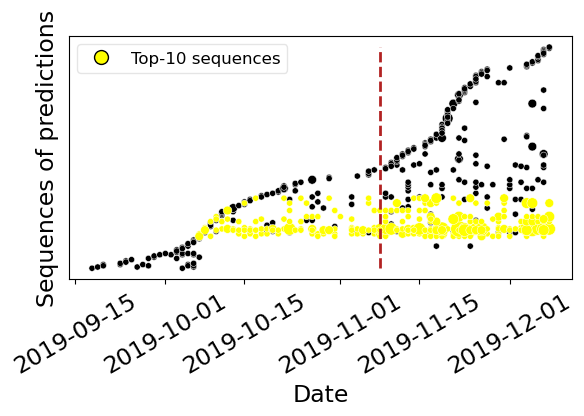

In [48]:
fig, axs = plt.subplots(figsize =(6, 4))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(20, 20*unique_associated_sessions.shape[0] + 1, 20))}
colors = {1:"yellow", 0:"black"}
sns.scatterplot(df_associated_sessions_per_date_not_of_interest, x = "date", y = "Prediction_id", color = "black", size = "associated_sessions", sizes = sizes, ax = axs, legend = None)
sns.scatterplot(df_associated_sessions_per_date_of_interest, x = "date", y = "Prediction_id", color = "yellow", size = "associated_sessions", sizes = sizes, ax = axs, legend = None)
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

handle = Line2D([0], [0], label=f"Top-10 sequences", markersize=20, markerfacecolor="yellow", linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
axs.legend(handles=[handle], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()

#### Isolate info on them

In [49]:
top_birth_and_occurrences = birth_and_occurrences[(birth_and_occurrences.date >= lower_date_threshold) & \
                                                (birth_and_occurrences.date <= upper_date_threshold) & \
                                                (birth_and_occurrences.associated_sessions >= session_threshold)]
print(f"Selected top {top_birth_and_occurrences.shape[0]} sequences")
top_birth_and_occurrences.head(2)

Selected top 11 sequences


Models_predictions        date  \
12  Discovery -- Discovery -- Discovery -- Discove...  2019-10-12   
22  Discovery -- Discovery -- Discovery -- Discove...  2019-10-10   

    associated_sessions  
12                   14  
22                   13

In [50]:
top_birth_and_occurrences["len_prediction"] = top_birth_and_occurrences.Models_predictions.apply(lambda prediction: len(prediction.split(" -- ")))
top_birth_and_occurrences["len_prediction"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


12     220
22     220
23     220
52     220
79     220
101    220
123     34
161    199
162    199
167    211
170    211
Name: len_prediction, dtype: int64

#### Create fixed size representations with padding

##### Convert each prediction into a number

In [51]:
top_birth_and_occurrences["label"] = top_birth_and_occurrences.apply(lambda row: f"Birth: {row.date.strftime('%b. %d, %Y').rjust(10)} - Associated sessions: {str(row.associated_sessions).rjust(3)}", axis = 1)
top_birth_and_occurrences.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Models_predictions        date  \
12  Discovery -- Discovery -- Discovery -- Discove...  2019-10-12   
22  Discovery -- Discovery -- Discovery -- Discove...  2019-10-10   

    associated_sessions  len_prediction  \
12                   14             220   
22                   13             220   

                                              label  
12  Birth: Oct. 12, 2019 - Associated sessions:  14  
22  Birth: Oct. 10, 2019 - Associated sessions:  13

In [52]:
with open("../../../Classification/Datasets/Mitigation/labels.txt", "r") as f:
    labels = [el.strip() for el in f.readlines()]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {v: k for k, v in id2label.items()}

In [53]:
import math 
max_lenght = top_birth_and_occurrences.len_prediction.max()
representation = top_birth_and_occurrences.Models_predictions.values
padded_representation = []
set_roles = set()
for it, el in enumerate(representation):
    print(it, top_birth_and_occurrences.iloc[it].label)
    new_representation = []
    for word in el.split(" -- "):
        new_representation.append(label2id[word])
        set_roles.add(word)
    missing_elements = max_lenght - len(new_representation)
    for it in range(missing_elements):
        new_representation.append(7)
    padded_representation.append(new_representation)
padded_representation = np.array(padded_representation)
padded_representation.shape

0 Birth: Oct. 12, 2019 - Associated sessions:  14
1 Birth: Oct. 10, 2019 - Associated sessions:  13
2 Birth: Oct. 07, 2019 - Associated sessions:  40
3 Birth: Oct. 08, 2019 - Associated sessions:  51
4 Birth: Oct. 07, 2019 - Associated sessions:  24
5 Birth: Oct. 17, 2019 - Associated sessions:  17
6 Birth: Oct. 15, 2019 - Associated sessions:  22
7 Birth: Oct. 10, 2019 - Associated sessions:  23
8 Birth: Oct. 08, 2019 - Associated sessions: 104
9 Birth: Oct. 09, 2019 - Associated sessions:  23
10 Birth: Oct. 08, 2019 - Associated sessions:  13


(11, 220)

In [54]:
plot = False
if plot:
    fig, axs = plt.subplots(figsize =(12, 4))
    fontsize = 15
    sns.heatmap(padded_representation, cmap = cmap, vmin=-0.5, vmax=7.5, linewidth = 0.003, cbar = False, linecolor = "black", yticklabels=False, xticklabels=False, ax = axs)
    #colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=len(new_role2color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', ticks=[key + .5 for key in list(new_role2color.keys())] , pad=0.02)
    cbar.ax.set_yticklabels(label_names)  # vertically oriented colorbar
    axs.set_ylabel("Top sequences", fontsize = fontsize + 2)
    axs.set_xlabel("Word", fontsize = fontsize + 2)
    plt.tight_layout()


In [55]:
to_visualize = [8, 3, 6]

In [56]:
label_names = ['Execution', 'Discovery', 'Persistence','Defense Evasion','Padding']

In [57]:
label_names

['Execution', 'Discovery', 'Persistence', 'Defense Evasion', 'Padding']

In [58]:
from matplotlib.colors import ListedColormap
new_role2color = {label2id[key]:value for (key, value) in hex_role2color.items() if key in label_names}
new_role2color[7] = "#FFFFFF"
new_role2color = dict(sorted(new_role2color.items()))
#label_names = list(id2label.values()) + ["Padding"]
cmap = ListedColormap([new_role2color[key] for key in new_role2color.keys()])

In [59]:
keys_to_keep = {key:value for (key, value) in new_role2color.items() if key in [0, 1, 2, 4, 7]}
keys_to_keep

{0: '#1ac938', 1: '#023eff', 2: '#ff7c00', 4: '#e8000b', 7: '#FFFFFF'}

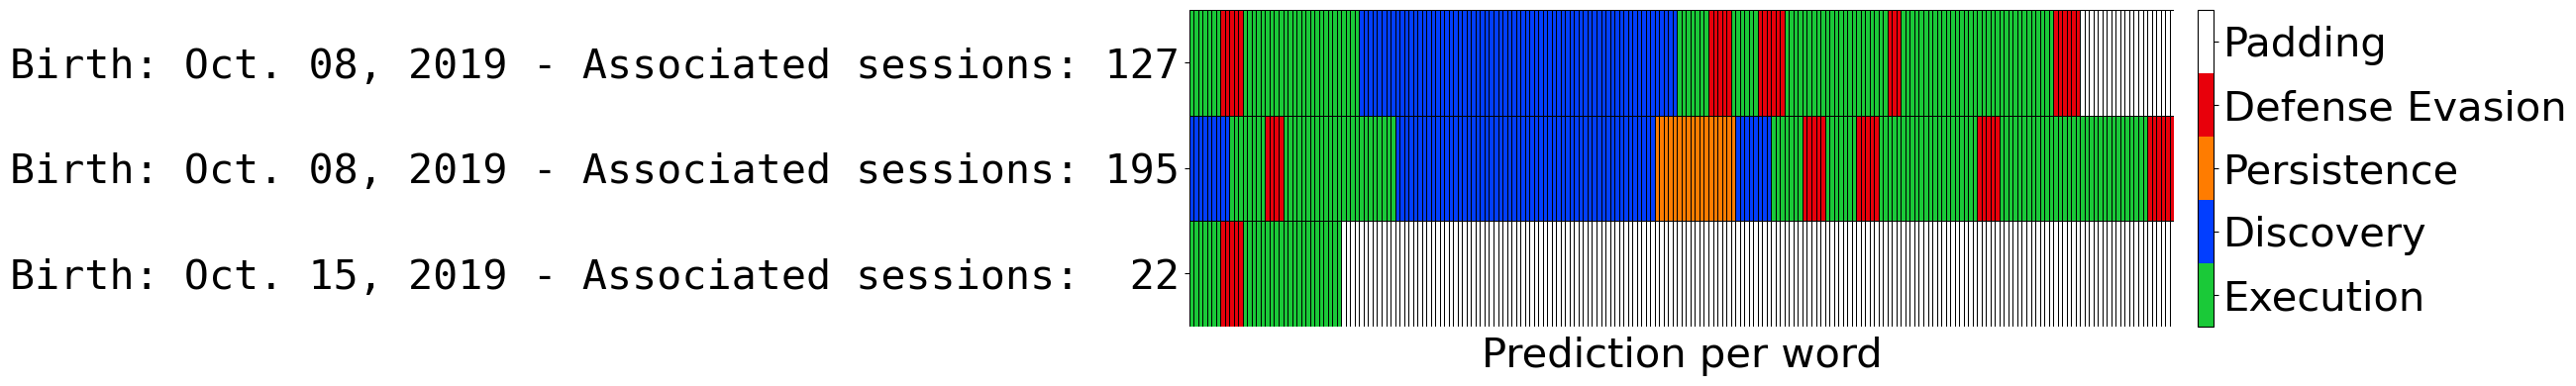

In [60]:
fig, axs = plt.subplots(figsize =(25, 4))
fontsize = 30

sns.heatmap(padded_representation[to_visualize,:], cmap = cmap, vmin=-0.5, vmax=5.5, linewidth = 0.5, cbar = False, linecolor = "black", yticklabels=False, xticklabels=False, ax = axs)
labels = top_birth_and_occurrences.iloc[to_visualize].label.values
labels[1] = "Birth: Oct. 08, 2019 - Associated sessions: 195"
labels[0] = labels[0].replace("104", "127")
#colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=len(keys_to_keep))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', ticks=[it + .5 for it in range(len(keys_to_keep))] , pad=0.02)
cbar.ax.set_yticklabels(label_names, fontsize = fontsize)  # vertically oriented colorbar
axs.set_yticks(np.arange(.5, len(to_visualize) +.5))
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
axs.set_yticklabels(labels, fontsize = (fontsize))

#axs.set_ylabel("Top sequences", fontsize = fontsize + 2)
axs.set_xlabel("Prediction per word", fontsize = fontsize)
plt.tight_layout()
plt.savefig("./Inference_results/4_Forensic/fingerprints.pdf", bbox_inches='tight')

#### We will compare prototypes
##### Remember that within the same family we work on "fixed size" (each family of prediction has the same number of words)

In [61]:
from tqdm import tqdm
families_attacks = corpus_of_chosen_word.Models_predictions.unique() # Obtain set of "families"
df_prototypes = []
for family in tqdm(families_attacks):
    # Select the corresponding sessions
    attacking_sessions = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == family][["full_session"]] 
    
    splitted_sessions = attacking_sessions["full_session"].str.split(' ', expand=True)
    assert not splitted_sessions.isnull().values.any(), "Error, NaN in the dataset"
    # Count the number of unique elements per column (each column corresponds to a word)
    prototype = splitted_sessions.nunique().to_frame().T.values
    associated_sessions = birth_and_occurrences[birth_and_occurrences.Models_predictions == family]["associated_sessions"].iloc[0]
    prototype = np.divide(prototype, associated_sessions / 100) 

    # Save how many variable elements there are per family
    varying_elements = len(prototype[(prototype != 1)])
    percentage_varying_elements = varying_elements / prototype.shape[1] * 100
    # Also save the number of associated sessions per family
    associated_sessions = attacking_sessions.shape[0]
    df_prototypes.append([family, associated_sessions, percentage_varying_elements, prototype])

df_prototypes = pd.DataFrame(df_prototypes, columns = ["Models_predictions", "associated_sessions", "percentage_varying_elements", "prototype"])
df_prototypes.head(2)

100%|██████████| 182/182 [00:03<00:00, 51.49it/s]


Models_predictions  associated_sessions  \
0  Execution -- Execution -- Execution -- Executi...                    2   
1  Execution -- Execution -- Execution -- Executi...                    3   

   percentage_varying_elements  \
0                        100.0   
1                        100.0   

                                           prototype  
0  [[50.0, 50.0, 100.0, 50.0, 50.0, 100.0, 50.0, ...  
1  [[33.333333333333336, 33.333333333333336, 100....

In [62]:
first_seq = top_birth_and_occurrences.iloc[8].Models_predictions
second_seq = top_birth_and_occurrences.iloc[3].Models_predictions
third_seq = top_birth_and_occurrences.iloc[9].Models_predictions
fourth_seq = top_birth_and_occurrences.iloc[6].Models_predictions

selected_prototypes = df_prototypes[df_prototypes.Models_predictions.isin([first_seq, second_seq, third_seq, fourth_seq])]
selected_prototypes.head(2)

Models_predictions  associated_sessions  \
31  Discovery -- Discovery -- Discovery -- Discove...                   51   
33  Execution -- Execution -- Execution -- Executi...                  104   

    percentage_varying_elements  \
31                        100.0   
33                        100.0   

                                            prototype  
31  [[1.9607843137254901, 1.9607843137254901, 1.96...  
33  [[0.9615384615384615, 0.9615384615384615, 100....

#### Idea here is that, since working withing the same family, we have guarantees that all sessions associated to that family will have the same number of words
##### If that is the case, we can then visualize which are the n-bit changing

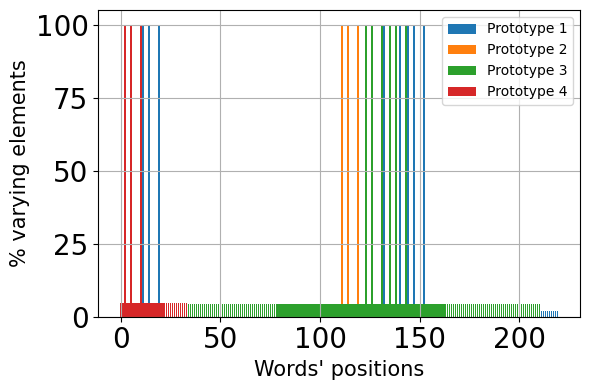

In [63]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(6,4))
fontsize = 20
random_words = []
for i in range(selected_prototypes.shape[0]):
    to_plot = selected_prototypes.iloc[i].prototype[0]
    axs.bar(np.arange(to_plot.shape[0]), to_plot, label = f"Prototype {i + 1}")
    index_random_word = [it for it, el in enumerate(to_plot) if el>5]
    random_words.append(index_random_word)

axs.set_xlabel("Words' positions", fontsize = fontsize - 5)
axs.set_ylabel('% varying elements', fontsize = fontsize - 5)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.legend()
axs.grid()
plt.tight_layout()
plt.show()

##### Prototypes say that we could basically pick any sessions from the two sequences (only random words changing)

In [64]:
example_first = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == first_seq].full_session.iloc[0]
example_second = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == second_seq].full_session.iloc[0]
example_third = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == third_seq].full_session.iloc[0]
example_fourth= corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == fourth_seq].full_session.iloc[0]

print(f"\nFirst example:\n")
for word, prediction in zip(first_seq.split(" -- "), example_first.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nSecond example:\n")
for word, prediction in zip(second_seq.split(" -- "), example_second.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nThird example:\n")
for word, prediction in zip(third_seq.split(" -- "), example_third.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nFourth example:\n")
for word, prediction in zip(fourth_seq.split(" -- "), example_fourth.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")


First example:

Execution - scp -- Execution - -t -- Execution - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Execution - ; -- Execution - LC_ALL=C -- Execution - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Execution - ; -- Defense Evasion - LC_ALL=C -- Defense Evasion - rm -- Defense Evasion - -f -- Defense Evasion - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Defense Evasion - ; -- Execution - LC_ALL=C -- Execution - chattr -- Execution - -i -- Execution - -a -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - rm -- Execution - -f -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - rmdir -- Execution - ~/.dhpcd -- Execution - ; -- Execution - scp -- Execution - -t -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - echo -- Execution - ~ -- Execution - ; -- Discovery - LC_ALL=C -- Discovery - chattr -- Discovery - -i -- Discovery - -a -- Discovery - /etc/shadow -- Discovery

In [71]:
example_first

'scp -t ~/kj22a7yyjfhlaqsf7iifwm7xiu ; LC_ALL=C ~/kj22a7yyjfhlaqsf7iifwm7xiu ; LC_ALL=C rm -f ~/kj22a7yyjfhlaqsf7iifwm7xiu ; LC_ALL=C chattr -i -a ~/.dhpcd ; LC_ALL=C rm -f ~/.dhpcd ; LC_ALL=C rmdir ~/.dhpcd ; scp -t ~/.dhpcd ; LC_ALL=C ~/.dhpcd ; LC_ALL=C echo ~ ; LC_ALL=C chattr -i -a /etc/shadow ; LC_ALL=C passwd ; LC_ALL=C passwd ; LC_ALL=C passwd test ; LC_ALL=C passwd test ; LC_ALL=C passwd oracle ; LC_ALL=C passwd oracle ; LC_ALL=C passwd test1 ; LC_ALL=C passwd test1 ; LC_ALL=C chattr +a /etc/shadow ; LC_ALL=C mkdir -p ~/.ssh ; LC_ALL=C chmod 700 ~/.ssh ; LC_ALL=C grep "ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCuhPmv3xdhU7JbMoc/ecBTDxiGqFNKbe564p4aNT6JbYWjNwZ5z6E4iQQDQ0bEp7uBtB0aut0apqDF/SL7pN5ybh2X44aCwDaSEB6bJuJi0yMkZwIvenmtCA1LMAr2XifvGS/Ulac7Qh5vFzfw562cWC+IOI+LyQZAcPgr+CXphJhm8QQ+O454ItXurQX6oPlA2rNfF36fnxYss1ZvUYC80wWTi9k2+/XR3IoQXZHKCFsJiwyKO2CY+jShBbDBbtdOX3/ksHNVNStA/jPE0HYD7u6V2Efjv9K+AEbklMsytD9T60Iu3ua+ugBrP5hL7zAjPHpXH8qW4Ku7dySZ4yvH" ~/.ssh/authorized_keys ; LC_ALL=C

In [65]:
examples = [example_first, example_second, example_third, example_fourth]
for it, random_words_example in enumerate(random_words):
    print(f"Random words for sequence {it + 1}:")
    for it_2 in random_words_example:
        print(f"Word at index {it_2}: {examples[it].split(' ')[it_2]}")
    print()

Random words for sequence 1:
Word at index 11: ;
Word at index 14: -i
Word at index 19: rm
Word at index 132: ;
Word at index 135: /tmp/knrm
Word at index 140: ;
Word at index 144: LC_ALL=C
Word at index 147: ;
Word at index 152: $SHELL

Random words for sequence 2:
Word at index 2: /etc/rc.local
Word at index 5: LC_ALL=C
Word at index 10: -t
Word at index 111: grep
Word at index 114: ~/.ssh/authorized_keys
Word at index 119: AAAAB3NzaC1yc2EAAAADAQABAAABAQDTiGm9b44ZjkQoMkcGuVsC8SGW7a9aFODS6nb64WnMwBwKPja7k56LyBBdVRm+MeKecx6Q/qLn5J+ggJ6um/LoCjKJLrX2dFOjGdyR4ZjnVBwibgr8PLrPoo7bUkaR3DMjfhcmoRlFrj51aN6g0TYHejCmug3TRpg37djYKqJ539iGNcmj021ZlzDBrjfIxUY849O72GsMuytk8n3K6XFxHj8gHyOsB7NgyvE39x9/SoGq2gkQS6TFun6dhmsr+ORokfS2265RwbdEOfnwL2LnQNuhiePlOUHRqzpc0K2pu9TGo1vNRIGSymCatMUNgnNX3tfcuMP5e8f1xDVh7fx3
Word at index 123: netstat
Word at index 126: LC_ALL=C
Word at index 131: -t

Random words for sequence 3:
Word at index 2: ~/r3ilc1yme24l9qbwps05tnq4ab
Word at index 5: ~/r3ilc1yme24l9qbwps05tnq4a

#### Another visualization

In [66]:
new_selected_prototypes = selected_prototypes.copy()
new_selected_prototypes["prototype"] = new_selected_prototypes["prototype"].apply(lambda el: el[0])
new_selected_prototypes["len_prototype"] = new_selected_prototypes["prototype"].apply(lambda el: len(el))
max_len = new_selected_prototypes["len_prototype"].max()
def pad_prototypes(row):
    len_prototype = row.len_prototype
    padded_prototype = [el for el in row.prototype]
    for it in range(max_len - len_prototype):
        padded_prototype.append(math.nan)
    return np.array(padded_prototype)
new_selected_prototypes["padded_prototype"] = new_selected_prototypes.apply(lambda row: pad_prototypes(row), axis = 1)
new_selected_prototypes

Models_predictions  associated_sessions  \
31  Discovery -- Discovery -- Discovery -- Discove...                   51   
33  Execution -- Execution -- Execution -- Executi...                  104   
36  Execution -- Execution -- Execution -- Executi...                   23   
53  Execution -- Execution -- Execution -- Executi...                   22   

    percentage_varying_elements  \
31                        100.0   
33                        100.0   
36                        100.0   
53                        100.0   

                                            prototype  len_prototype  \
31  [1.9607843137254901, 1.9607843137254901, 1.960...            220   
33  [0.9615384615384615, 0.9615384615384615, 100.0...            199   
36  [4.3478260869565215, 4.3478260869565215, 100.0...            211   
53  [4.545454545454546, 4.545454545454546, 100.0, ...             34   

                                     padded_prototype  
31  [1.9607843137254901, 1.9607843137254901, 1.960...  
33  [0.9615384615384615, 0.9615384615384615, 100.0...  
36  [4.3478260869565215, 4.3478260869565215, 100.0...  
53  [4.545454545454546, 4.545454545454546, 100.0, ...

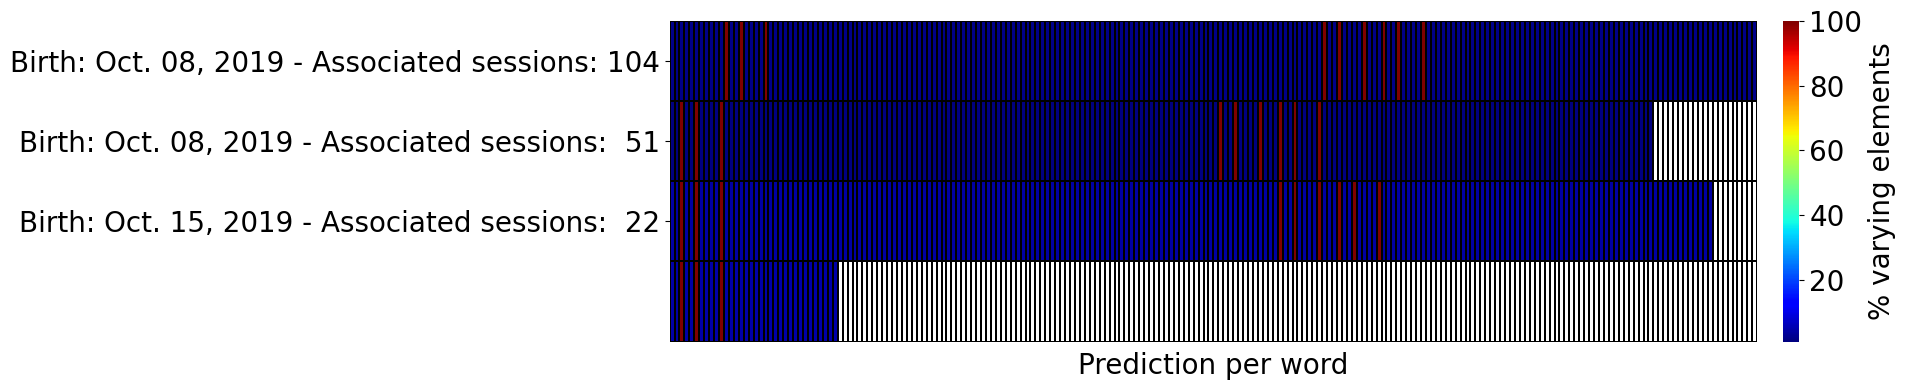

In [67]:
fig, axs = plt.subplots(figsize =(20, 4))
fontsize = 20
padded_prototype = np.array(list(new_selected_prototypes["padded_prototype"].values))
sns.heatmap(padded_prototype, cmap = "jet", linewidth = 0.003, cbar = True, linecolor = "black", yticklabels=False, 
            xticklabels=False, ax = axs, cbar_kws={"pad": 0.02})
cbar = axs.collections[0].colorbar
cbar.ax.set_ylabel("% varying elements", fontsize = fontsize)
cbar.ax.tick_params(labelsize=fontsize)
axs.set_yticks(np.arange(.5, len(to_visualize) +.5))
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_xlabel("Prediction per word", fontsize = fontsize )
plt.tight_layout()

### Extra

#### Try finding the closest to a "\~/.dhpcd" sequence, which however does not contain "~/.dhpcd"
##### This might be useful to capture similarities between attacks beyond names

##### Isolate sequences that do not contain "~/.dhpcd"

In [68]:
pd.options.mode.chained_assignment = None  # default='warn'
destinations = predicted_corpus[~predicted_corpus.full_session.str.contains("~/.dhpcd")].Models_predictions.unique() 
df_destinations = pd.DataFrame(destinations, columns = ["destinations"])
df_destinations["oneHotEncoded"] = df_destinations["destinations"].apply(lambda prediction: "".join([str(label2id[el]) for el in prediction.split(" -- ")]))
df_destinations.head(2)

destinations  \
0  Discovery -- Discovery -- Discovery -- Discove...   
1  Discovery -- Discovery -- Discovery -- Discove...   

                                       oneHotEncoded  
0  1111111111111111111111111111111111111111111111...  
1  1111111111111111111111111111111111111111111111...

In [69]:
departure = sessions_per_seq.sort_values(by = "associated_sessions", ascending = False).iloc[0].Models_predictions
oneHot_departure = "".join([str(label2id[el]) for el in departure.split(" -- ")])

##### Calculate distances wrt them

In [70]:
%%time
from Levenshtein import distance as lev
from itertools import permutations
from tqdm import tqdm

distances = []
for destination_id in range(df_destinations.shape[0]):
    destination = df_destinations.iloc[destination_id].destinations
    destination_repr = df_destinations.iloc[destination_id].oneHotEncoded
    distance = lev(oneHot_departure, destination_repr)
    max_length = np.max([len(destination.split(" -- ")), len(departure.split(" -- "))])
    distances.append({
        "origin" : departure,
        "destination" : destination,
        "distance" : (distance/max_length)
    })
    
df_distances = pd.DataFrame(distances)
df_distances.sort_values(by = "distance").head(2)

ModuleNotFoundError: No module named 'Levenshtein'

##### Calculate CDF

In [ ]:
cdf_distances_not_containing = df_distances.value_counts("distance").sort_index()
cdf_distances_not_containing = np.cumsum(cdf_distances_not_containing)/np.sum(cdf_distances_not_containing)

#### Do the same for sequences containing the word under analysis

##### Isolate sequences that contain "~/.dhpcd"

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
destinations = predicted_corpus[predicted_corpus.full_session.str.contains("~/.dhpcd")].Models_predictions.unique() 
df_destinations = pd.DataFrame(destinations, columns = ["destinations"])
df_destinations["oneHotEncoded"] = df_destinations["destinations"].apply(lambda prediction: "".join([str(label2id[el]) for el in prediction.split(" -- ")]))
df_destinations.head(2)

In [ ]:
departure = sessions_per_seq.sort_values(by = "associated_sessions", ascending = False).iloc[0].Models_predictions
oneHot_departure = "".join([str(label2id[el]) for el in departure.split(" -- ")])

##### Calculate distances wrt them

In [ ]:
%%time
from Levenshtein import distance as lev
from itertools import permutations
from tqdm import tqdm

distances = []
for destination_id in range(df_destinations.shape[0]):
    destination = df_destinations.iloc[destination_id].destinations
    destination_repr = df_destinations.iloc[destination_id].oneHotEncoded
#for key, value in zip(perms_keys, perms_values):
    distance = lev(oneHot_departure, destination_repr)
    max_length = np.max([len(destination.split(" -- ")), len(departure.split(" -- "))])
    distances.append({
        "origin" : departure,
        "destination" : destination,
        "distance" : (distance/max_length)
    })
    
df_distances = pd.DataFrame(distances)
df_distances.sort_values(by = "distance").head(2)

##### Calculate CDF

In [ ]:
cdf_distances_containing = df_distances.value_counts("distance").sort_index()
cdf_distances_containing = np.cumsum(cdf_distances_containing)/np.sum(cdf_distances_containing)

In [ ]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(6,3))
fontsize = 18
axs.plot(cdf_distances_not_containing.reset_index()["distance"], cdf_distances_not_containing.reset_index()[0], linewidth = 2, label = f"Not containing ~/.dhpcd")
axs.plot(cdf_distances_containing.reset_index()["distance"], cdf_distances_containing.reset_index()[0], linewidth = 2, label = f"Containing ~/.dhpcd")
axs.set_xlabel('Norm. edit distances wrt chosen sequence', fontsize = fontsize + 3)
axs.set_ylabel('ECDF', fontsize = fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.set_xticks(np.arange(0, 1.1, 0.2))
axs.legend(fontsize = fontsize - 8)
axs.grid()
plt.tight_layout()
plt.show()